# Tracking an object using the Kalman filter





Consider an object moving in $R^2$.
We assume that we observe a noisy version of its location at each time step.
We want to track the object and possibly forecast its future motion.
We now show how to do this using a simple linear Gaussian SSM, combined with 
the Kalman filter algorithm.

Let the hidden state represent
the position and velocity of the object,
$z_t =\begin{pmatrix} u_t & \dot{u}_t & v_t & \dot{v}_t \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
The process evolves in continuous time, but if we discretize it with step size $\Delta$,
we can write the dynamics as the following linear system:

\begin{align*}
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{z_t}
  = 
\underbrace{
\begin{pmatrix}
1 & 0 & \Delta & 0 \\
0 & 1 & 0 & \Delta\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} u_{t-1} \\ \dot{u}_{t-1} \\ v_{t-1} \\ \dot{v}_{t-1} \end{pmatrix}}_{z_{t-1}}
+ q_t
\end{align*}

where $q_t \in R^4$ is the process noise, which we assume is Gaussian,
so  $q_t \sim N(0,Q)$.

Now suppose that at each discrete time point we
observe the location (but not the velocity).
We assume the observation is corrupted by  Gaussian noise.
Thus the observation model becomes

\begin{align*}
\underbrace{\begin{pmatrix}  y_{1,t} \\  y_{2,t} \end{pmatrix}}_{y_t}
  &=
    \underbrace{
    \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
    \end{pmatrix}
    }_{H}
    
\underbrace{\begin{pmatrix} u_t\\ \dot{u}_t \\ v_t \\ \dot{v}_t \end{pmatrix}}_{z_t}    
 + r_t
\end{align*}

where $r_t \sim N(0,R)$ is the observation noise.
We see that the observation matrix $H$ simply ``extracts'' the
relevant parts  of the state vector.


## Setup

In [2]:

try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [27]:
from jax import numpy as jnp
from jax import random as jr
from jax import vmap, grad
from matplotlib import pyplot as plt


from dynamax.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm.models.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm.inference import LGSSMParams, lgssm_smoother, lgssm_filter


## Create the model

In [18]:


state_dim = 4
emission_dim = 2
delta = 1.0

# Create object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# Random model parameters
params, _ = lgssm.random_initialization(jr.PRNGKey(0))

# Manually chosen parameters
mu0 = jnp.array([8.0, 10.0, 1.0, 0.0])
Sigma0 = jnp.eye(state_dim) * 0.1
F  = jnp.array([[1, 0, delta, 0],
                [0, 1, 0, delta],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
Q = jnp.eye(state_dim) * 0.001
H = jnp.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0]])
R = jnp.eye(emission_dim) * 1.0

params['initial']['mean'] = mu0
params['initial']['cov'] = Sigma0
params['dynamics']['weights'] = F
params['dynamics']['cov'] = Q
params['emissions']['weights'] = H
params['emissions']['cov'] = R

## Sample some data from the model

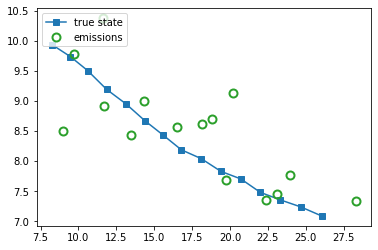

In [9]:
num_timesteps = 15
key = jr.PRNGKey(310)
x, y = lgssm.sample(params, key, num_timesteps)

# Plot Data
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig1, ax1 = plt.subplots()
ax1.plot(*x[:, :2].T, marker="s", color="C0", label="true state")
ax1.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="emissions")
ax1.legend(loc="upper left")



In [28]:

def plot_lgssm_posterior(post_means, post_covs, ax=None, ellipse_kwargs={}, legend_kwargs={}, **kwargs):
    """Plot posterior means and covariances for the first two dimensions of
     the latent state of a LGSSM.

    Args:
        post_means: array(T, D).
        post_covs: array(T, D, D).
        ax: matplotlib axis.
        ellipse_kwargs: keyword arguments passed to matplotlib.patches.Ellipse().
        **kwargs: passed to ax.plot().
    """
    if ax is None:
        fig, ax = plt.subplots()

    # This is to stop some weird behaviour where running the function multiple
    # #  times with an empty argument wouldn't reset the dictionary.
    # if ellipse_kwargs is None:
    #     ellipse_kwargs = dict()

    # if 'edgecolor' not in ellipse_kwargs:
    #     if 'color' in kwargs:
    #         ellipse_kwargs['edgecolor'] = kwargs['color']

    # Select the first two dimensions of the latent space.
    post_means = post_means[:, :2]
    post_covs = post_covs[:, :2, :2]

    # Plot the mean trajectory
    ax.plot(post_means[:, 0], post_means[:, 1], **kwargs)
    # Plot covariance at each time point.
    plot_uncertainty_ellipses(post_means, post_covs, ax, **ellipse_kwargs)

    ax.axis("equal")

    if "label" in kwargs:
        ax.legend(**legend_kwargs)

    return ax

## Perform online filtering



In [10]:
lgssm_posterior = lgssm.filter(params, y)

from dataclasses import dataclass
from dataclasses import fields
attributes = [field.name for field in fields(lgssm_posterior)]
print(attributes)

print(lgssm_posterior.filtered_means.shape)
print(lgssm_posterior.filtered_covariances.shape)
print(lgssm_posterior.marginal_loglik)
# The smoothed outputs are None


['marginal_loglik', 'filtered_means', 'filtered_covariances', 'smoothed_means', 'smoothed_covariances', 'smoothed_cross_covariances']
(15, 4)
(15, 4, 4)
-43.13845


<AxesSubplot:>

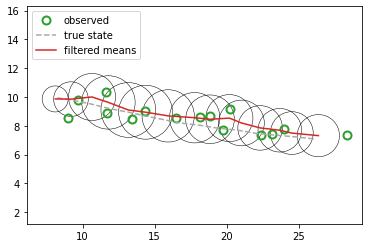

In [29]:
fig2, ax2 = plt.subplots()
ax2.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax2.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.filtered_means,
    lgssm_posterior.filtered_covariances,
    ax2,
    color="tab:red",
    label="filtered means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

## Perform offline smoothing

In [12]:
lgssm_posterior = lgssm.smoother(params, y)

<AxesSubplot:>

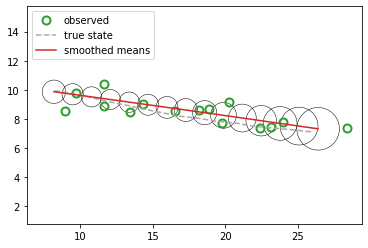

In [13]:
fig3, ax3 = plt.subplots()
ax3.plot(*y.T, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax3.plot(*x[:, :2].T, ls="--", color="darkgrey", label="true state")
plot_lgssm_posterior(
    lgssm_posterior.smoothed_means,
    lgssm_posterior.smoothed_covariances,
    ax3,
    color="tab:red",
    label="smoothed means",
    ellipse_kwargs={"edgecolor": "k", "linewidth": 0.5},
    legend_kwargs={"loc":"upper left"}
)

## Low-level interface to the underlying inference algorithms

We can also call the inference code directly, without having to make an LG-SSM object.
We just bundle the parameters together into an `LGSSMParams` dataclass and call
the underlying inference functions.

In [19]:
 # Specify the model parameters


inf_params = LGSSMParams(
    initial_mean=mu0, 
    initial_covariance=Sigma0,
    dynamics_matrix=F,
    dynamics_covariance=Q,
    emission_matrix=H,
    emission_covariance=R
)

filtered_posterior = lgssm_filter(inf_params, y) # Kalman filter
smoothed_posterior = lgssm_smoother(inf_params, y) # Kalman filter + smoother
assert jnp.allclose(lgssm_posterior.filtered_means, filtered_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.filtered_means, smoothed_posterior.filtered_means)
assert jnp.allclose(lgssm_posterior.smoothed_means, smoothed_posterior.smoothed_means)

## Tracking multiple objects in parallel


In [20]:
# Generate 4 sample trajectories

num_timesteps = 15
num_samples = 4
key = jr.PRNGKey(310)
keys = jr.split(key, num_samples)
xs, ys = vmap(lambda key: lgssm.sample(params, key, num_timesteps))(keys)



In [22]:
# vmap the inference

lgssm_posteriors = vmap(lambda y: lgssm.smoother(params, y))(ys)


In [23]:


def plot_kf_parallel(xs, ys, lgssm_posteriors):
    num_samples = len(xs)
    dict_figures = {}

    # Plot Data
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*xs[n, :, :2].T, ls="--", color=f"C{n}")
        ax.plot(*ys[n, ...].T, ".", color=f"C{n}", label=f"Trajectory {n+1}")
    ax.set_title("Data")
    ax.legend()
    dict_figures["missiles_latent"] = fig

    # Plot Filtering
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*ys[n, ...].T, ".")
        filt_means = lgssm_posteriors.filtered_means[n, ...]
        filt_covs = lgssm_posteriors.filtered_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f"C{n}",
            ellipse_kwargs={"edgecolor": f"C{n}", "linewidth": 0.5},
            label=f"Trajectory {n+1}",
        )
    ax.legend(fontsize=10)
    ax.set_title("Filtered Posterior")
    dict_figures["missiles_filtered"] = fig

    # Plot Smoothing
    fig, ax = plt.subplots()
    for n in range(num_samples):
        ax.plot(*ys[n, ...].T, ".")
        filt_means = lgssm_posteriors.smoothed_means[n, ...]
        filt_covs = lgssm_posteriors.smoothed_covariances[n, ...]
        plot_lgssm_posterior(
            filt_means,
            filt_covs,
            ax,
            color=f"C{n}",
            ellipse_kwargs={"edgecolor": f"C{n}", "linewidth": 0.5},
            label=f"Trajectory {n+1}",
        )
    ax.legend(fontsize=10)
    ax.set_title("Smoothed Posterior")
    dict_figures["missiles_smoothed"] = fig

    return dict_figures

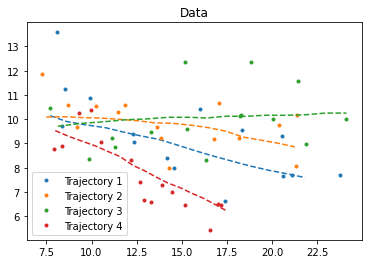

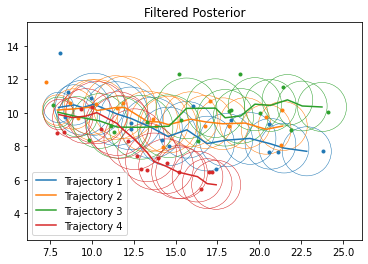

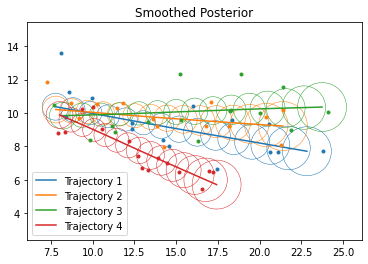

In [25]:
dict_figures = plot_kf_parallel(xs, ys, lgssm_posteriors)

In [26]:
for k, v in dict_figures.items():
    fname = k + ".pdf"
    print(fname)
    fig = v
    #fig.savefig(fname)

missiles_latent.pdf
missiles_filtered.pdf
missiles_smoothed.pdf
